<center>

# [`ProxNest`](https://github.com/astro-informatics/proxnest) - __Radio Interferometry Example__ Interactive Tutorial
---
Suppose we collect complete Fourier observations $y \in \mathbb{R}^M$ of some image $x \in \mathbb{R}^N$ under a forward model $\Phi = \mathsf{G}\mathsf{F}$, where $M \ll N$ and $\mathsf{G}$ / $\mathsf{F}$ are Fourier sub-sampling and transform respectively. Suppose further that our observational instrument introduces some aleoteric uncertainty which can be adequately modelled by a univariate Gaussian $n = \mathcal{N}(0, \sigma) \in \mathbb{R}^N$. In this case our measurement equation is given by $$y = \Phi x + n.$$

Under these conditions the inverse problem of infering $x$ given $y$ is heavily degenerate and thus breaks [Hadamards](https://en.wikipedia.org/wiki/Well-posed_problem) second condition: the solution is not unique and thus the inverse problem is ill-posed. Given that inferences of $x$ are degenerate it naturally makes more sense to consider the probability distribution of possible solutions; the posterior distribution. Here we use **proximal nested sampling** ([Cai *et al* 2022](https://arxiv.org/abs/2106.03646)), which allows us to sample from this posterior distribution, recovering both an estimate of $x$ and the plausibility of this estimate. Moreover, as this is a nested sampling algorithm we automatically recover the Bayesian evidence, which naturally allows us to carry out model comparison, through which one can *e.g.* determine which forward models $\Phi$ are favoured by the data, or calibrate hyper-parameters of the problem such as $\sigma$ and regularisation parameters $\lambda$.

In [1]:
import sys
import os
# Set GPU ID
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import numpy as np
import ProxNest as pxn
import ProxNest.utils as utils
import ProxNest.sampling as sampling
import ProxNest.optimisations as optimisations
import ProxNest.operators as operators

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tick

# plt.style.use('dark_background')
plt.rcParams["font.family"] = "serif"




In [2]:
import scipy.io as sio
from astropy.io import fits
from skimage import transform

def load_imgs(img_name, repo_dir):
    """Load radio images.
    
    Load radio image and the corresponding Fourier mask.
    The preprocessing follows X. Cai's implementation used for his article.

    Args:
        img_name (str): Radio image name
        repo_dir (str): path to the repository directory

    Returns:
        img (np.ndarray): preprocessed radio image
        mat_mask (np.ndarray): Fourier mask
    """
    # Load img
    img_path = repo_dir + '/data/imgs/{:s}.fits'.format(img_name)
    img_data = fits.open(img_path, memmap=False)

    # Loading the image and cast it to float
    img = np.squeeze(np.copy(img_data[0].data)).astype(np.float64)
    # Flipping data
    img = np.flipud(img)

    # Resize image 
    if img_name == 'CYN':
        img = transform.resize(img, [256, 512], order=3, anti_aliasing=True)

    if img_name == 'W28' or img_name == '3c288':
        img = transform.resize(img, [256, 256], order=3, anti_aliasing=True)

    # Normalise
    img = img - np.min(img)
    img = img / np.max(img)

    # Load op from X Cai
    op_mask = sio.loadmat(
        repo_dir + '/data/operators_masks/' + img_name + '_fourier_mask.mat'
    )['Ma']

    # Matlab's reshape works with 'F'-like ordering
    mat_mask = np.reshape(np.sum(op_mask, axis=0), img.shape, order='F').astype(bool)

    return img, mat_mask


### Load an image and simulate some observations

In [3]:
# Load Image
dim = 64
ground_truth = np.load('../../data/galaxy_image_{}.npy'.format(dim))

# Normalise magnitude
ground_truth -= np.nanmin(ground_truth)
ground_truth /= np.nanmax(ground_truth)
ground_truth[ground_truth<0] = 0

In [4]:
repo_dir = '/disk/xray0/tl3/repos/large-scale-UQ'
img_name = 'M31'

dim = 256

# Load image and mask
ground_truth, mat_mask = load_imgs(img_name, repo_dir)

INSTRUME                                                                         [astropy.io.fits.card]


In [5]:
ground_truth -= np.nanmin(ground_truth)
ground_truth /= np.nanmax(ground_truth)
ground_truth[ground_truth<0] = 0

### Construct linear operators and mock simulated observations for our stated problem

In [6]:
np.random.seed(0)

# A mock radio imaging forward model with half of the Fourier coefficients masked
phi = operators.sensing_operators.MaskedFourier(dim, 0.5)
phi.mask = np.copy(mat_mask)

# A wavelet dictionary in which we can promote sparsity
psi = operators.wavelet_operators.db_wavelets(["db6"], 2, (dim, dim))

In [7]:
# Simulate mock noisy observations y
y = phi.dir_op(ground_truth)
ISNR = 15
sigma = np.sqrt(np.mean(np.abs(y)**2)) * 10**(-ISNR/20)
n = np.random.normal(0, sigma, y[y!=0].shape)

# Simulate mock noisy observations
y[y!=0] += n

### Define all necessary parameters and posteior lambda functions

In [8]:
alpha = 1e-6
varepsilon = sigma**2
L = 1.
L_y = 0.

lamb = 0.1 * 0.5 * (1/(2 * L_y + alpha * L / varepsilon ))
delta = 0.1 * (1/3) * (1/ (L_y + 1/lamb + alpha * L / varepsilon))

print('varepsilon: ', varepsilon)
print('varepsilon * alpha: ', varepsilon * alpha)
print('lamb: ', lamb)
print('delta: ', delta)


varepsilon:  61.0358740426651
varepsilon * alpha:  6.10358740426651e-05
lamb:  3051793.702133255
delta:  96882.33975026206


In [9]:

alpha = 3.5e-7  # 0.00001

delta_step_DnCNN = 1e-7
lamb_DnCNN = 5 * 1e-7
gamma_DnCNN = alpha * sigma**2


In [10]:
delta_step_WAV = 1e-7
lamb_WAV = 5. * delta_step_WAV
gamma_WAV = 5. * delta_step_WAV

# Regularisation parameter
WAV_reg_param = 5e4


In [11]:
# Parameter dictionary associated with optimisation problem of resampling from the prior subject to the likelihood iso-ball
params_WAV = utils.create_parameters_dict(
           y = np.copy(y),           # Measurements i.e. data
         Phi = phi,                  # Forward model
     epsilon = 1e-3,                 # Radius of L2-ball of likelihood 
       tight = False,                # Is Phi a tight frame or not?
          nu = 1,                    # Bound on the squared-norm of Phi
         tol = 1e-10,                # Convergence tolerance of algorithm
    max_iter = 200,                  # Maximum number of iterations
     verbose = 0,                    # Verbosity level
           u = 0,                    # Initial vector for the dual problem
         pos = True,                 # Positivity flag
     reality = True                  # Reality flag
)

params_DnCNN = utils.create_parameters_dict(
           y = np.copy(y),           # Measurements i.e. data
         Phi = phi,                  # Forward model
     epsilon = 1e-3,                 # Radius of L2-ball of likelihood 
       tight = False,                # Is Phi a tight frame or not?
          nu = 1,                    # Bound on the squared-norm of Phi
         tol = 1e-10,                # Convergence tolerance of algorithm
    max_iter = 200,                  # Maximum number of iterations
     verbose = 0,                    # Verbosity level
           u = 0,                    # Initial vector for the dual problem
         pos = True,                 # Positivity flag
     reality = True                  # Reality flag
)

# Options dictionary associated with the overall sampling algorithm
options_DnCNN = utils.create_options_dict(
    samplesL = 1e2, # 2e3,                  # Number of live samples
    samplesD = 2.5e3,  # 4e4,                  # Number of discarded samples 
    thinning = 2e1, # 1e2,                  # Thinning factor (to mitigate correlations)
       delta = delta_step_DnCNN, #1e-8,    # Discretisation stepsize
       lamb = lamb_DnCNN,
        burn = 1e2, # 1e3,                  # Number of burn in samples
       sigma = sigma,                # Noise standard deviation of degraded image
       gamma = gamma_DnCNN,             # Gamma parameter of the prior term. Using noise variance
)

options_WAV = utils.create_options_dict(
    samplesL = 1e2,# 2e3,                  # Number of live samples
    samplesD = 2.5e3, # 4e4,                  # Number of discarded samples 
    thinning = 2e1,# 1e2,                  # Thinning factor (to mitigate correlations)
       delta = delta_step_WAV, #1e-8,    # Discretisation stepsize
       lamb = lamb_WAV,
        burn = 1e2,# 1e3,                  # Number of burn in samples
       sigma = sigma,                # Noise standard deviation of degraded image
       gamma = gamma_WAV,             # Gamma parameter of the prior term. Using noise variance
)


In [12]:

# Lambda functions to evaluate cost function
LogLikeliL = lambda sol : - np.linalg.norm(y-phi.dir_op(sol))**2/(2*sigma**2)

# Lambda function for L1-norm wavelet prior backprojection steps
proxH_WAV = lambda x, T : operators.proximal_operators.l1_projection(x, T, WAV_reg_param, Psi=psi)


# Lambda function for L2-ball likelihood projection during resampling
proxB_WAV = lambda x, tau: optimisations.l2_ball_proj.sopt_fast_proj_B2(x, tau, params_WAV)

# Lambda function for L2-ball likelihood projection during resampling
proxB_DnCNN = lambda x, tau: optimisations.l2_ball_proj.sopt_fast_proj_B2(x, tau, params_DnCNN)


In [13]:
# Saved dir of the model in SavedModel format
saved_model_path = '/disk/xray0/tl3/repos/lexci_models/DnCNN/snr_15_model.pb'
# Load DnCNN denoiser prox
proxH_DnCNN = pxn.operators.learned_operators.prox_DnCNN(saved_model_path)


2023-06-22 15:06:57.706520: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-22 15:06:58.195061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38396 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:a1:00.0, compute capability: 8.0


### Select a starting position $X_0$ and execute the sampling method

In [14]:
# Create a 'dirty image' starting position
X0 = np.abs(phi.adj_op(np.copy(y)))

In [15]:
save_fig_dir = '/disk/xray0/tl3/repos/proxnest/debug/figs/'
save_var_dir = '/disk/xray0/tl3/repos/proxnest/debug/saved_vars/'

save_prefix_WAV = 'radio_WAV_delta_{:.1e}_lamb_{:.1e}_gamma_{:.1e}'.format(
    delta_step_WAV, lamb_WAV, gamma_WAV
)

save_prefix_DnCNN = 'radio_DnCNN_delta_{:.1e}_lamb_{:.1e}_gamma_{:.1e}'.format(
    delta_step_DnCNN, lamb_DnCNN, gamma_DnCNN
)


# DnCNN model

In [16]:

# Perform proximal nested sampling
NS_BayEvi_DnCNN, NS_Trace_DnCNN = sampling.proximal_nested.ProxNestedSampling(
    np.copy(X0), LogLikeliL, proxH_DnCNN, proxB_DnCNN, params_DnCNN, options_DnCNN
)


ProxNest || Initialise:   0%|          | 0/200 [00:00<?, ?it/s]2023-06-22 15:07:00.111366: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-06-22 15:07:00.785859: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
ProxNest || Initialise: 100%|██████████| 200/200 [00:49<00:00,  4.02it/s]
ProxNest || Populate: 100%|██████████| 2098/2098 [00:15<00:00, 139.11it/s]
ProxNest || Sample: 100%|██████████| 2500/2500 [15:51<00:00,  2.63it/s]
ProxNest || Compute Weights: 100%|██████████| 2500/2500 [00:00<00:00, 674108.65it/s]
ProxNest || Trapezium Integrate: 100%|██████████| 2498/2498 [00:00<00:00, 1416626.74it/s]
ProxNest || Estimate Variance: 100%|██████████| 2500/2500 [00:00<00:00, 335737.70it/s]
ProxNest || Compute Posterior Mean: 100%|██████████| 2500/2500 [00:00<00:00, 368593.93it/s]


In [17]:
print(NS_BayEvi_DnCNN)

[-3.76011298e+03  3.82686756e-01]


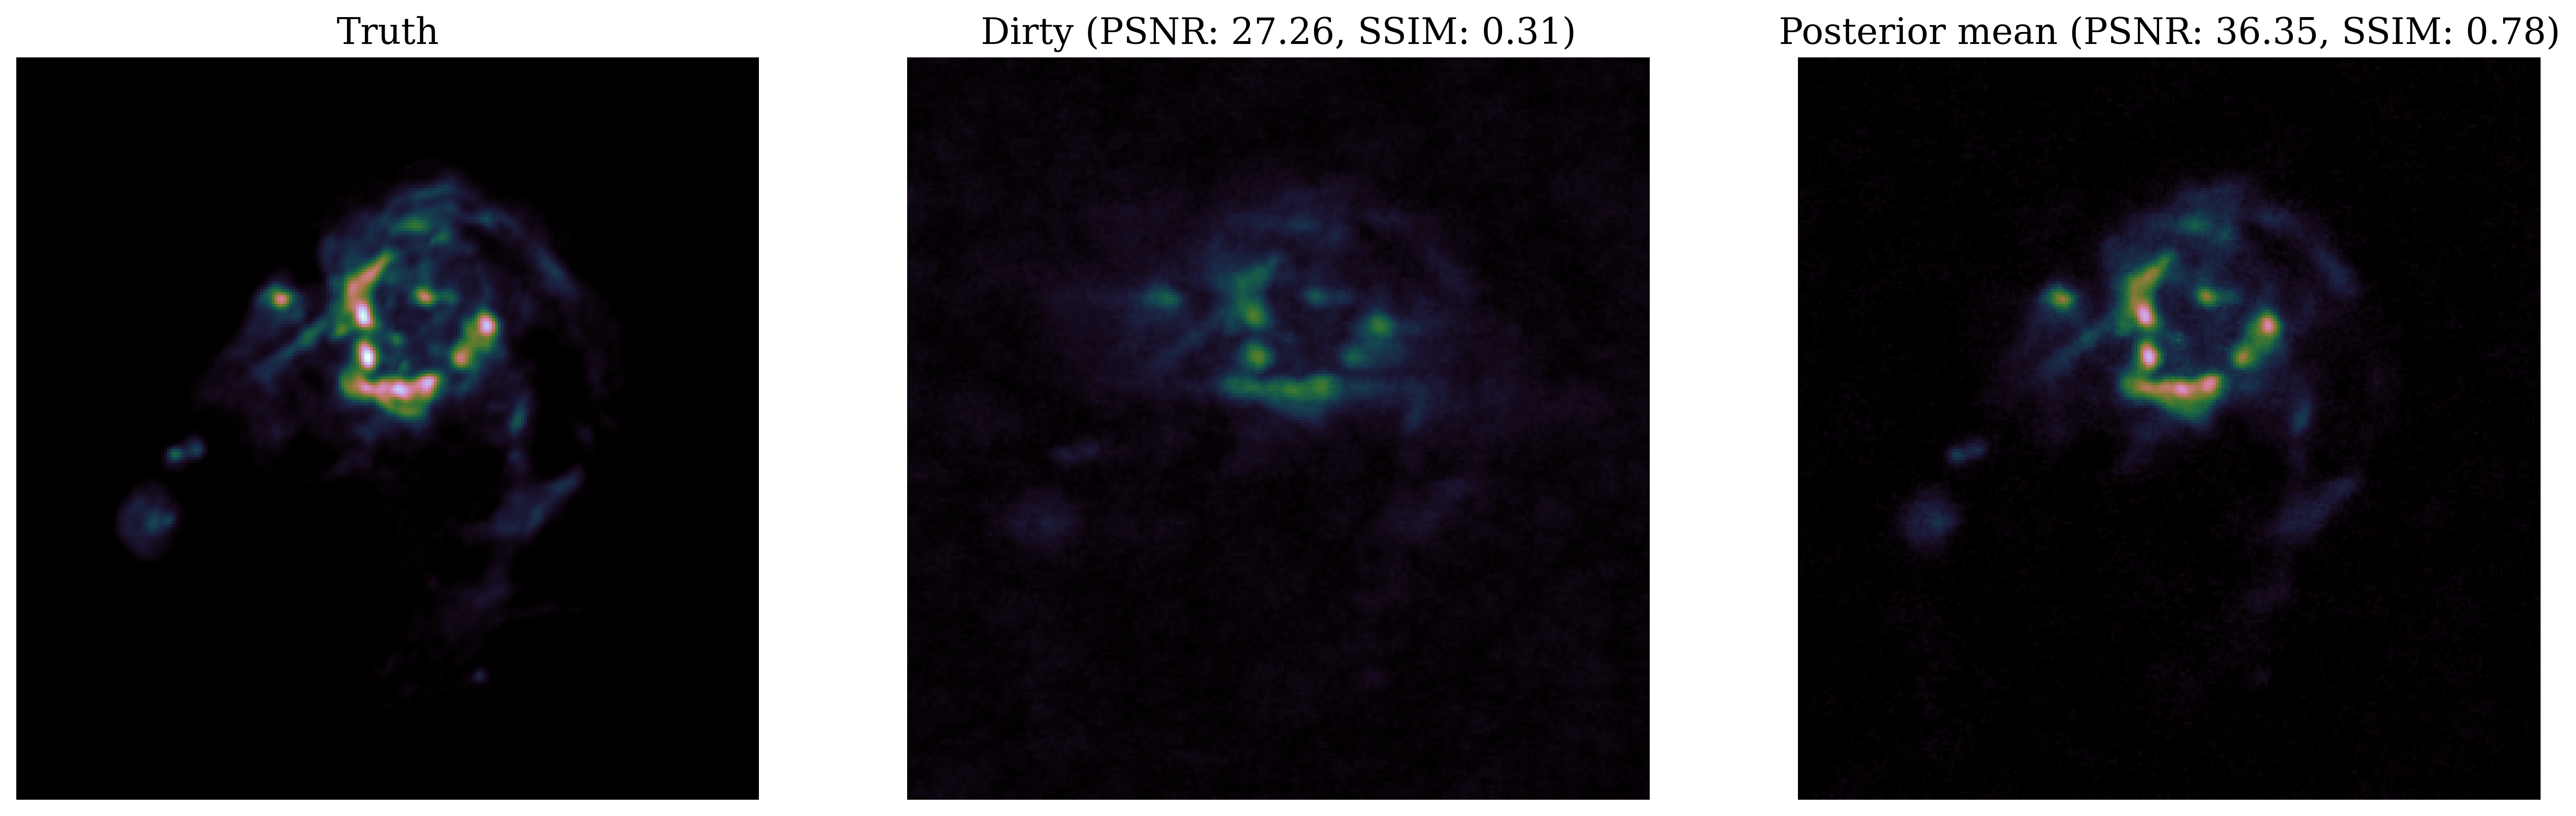

In [18]:
# DnCNN

images = [ground_truth, X0, NS_Trace_DnCNN['DiscardPostMean']]
labels = ["Truth", "Dirty", "Posterior mean"]

fig, axs = plt.subplots(1,3, figsize=(20,8), dpi=400)
for i in range(3):
    axs[i].imshow(images[i], cmap='cubehelix', vmax=np.nanmax(images), vmin=np.nanmin(images))
    if i > 0:   
        stats_str = ' (PSNR: {}, SSIM: {})'.format(
            round(psnr(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2),
            round(ssim(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2)
            )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')

# plt.savefig('{:s}{:s}_reconstruction_plot.pdf'.format(save_fig_dir, save_prefix_DnCNN))
plt.show()

dirty_DnCNN_SNR = psnr(ground_truth, X0, data_range=ground_truth.max()-ground_truth.min())
post_mean_DnCNN_SNR = psnr(ground_truth, NS_Trace_DnCNN['DiscardPostMean'], data_range=ground_truth.max()-ground_truth.min())


In [19]:
save_dict_DnCNN = {
    'ground_truth': ground_truth,
    'X0': X0,
    'dirty_SNR': dirty_DnCNN_SNR,
    'post_mean_SNR': post_mean_DnCNN_SNR,
    'NS_BayEvi': NS_BayEvi_DnCNN,
    'NS_Trace': NS_Trace_DnCNN,
    'options': options_DnCNN,
}

# try:
#     np.save('{:s}{:s}_saved_vars.pdf'.format(save_var_dir, save_prefix_DnCNN), save_dict_DnCNN, allow_pickle=True)
# except Exception as e:
#     print('cannot save variables')
#     print(e)


# WAV model

In [20]:

# Perform proximal nested sampling
NS_BayEvi_WAV, NS_Trace_WAV = sampling.proximal_nested.ProxNestedSampling(
    np.copy(X0), LogLikeliL, proxH_WAV, proxB_WAV, params_WAV, options_WAV
)



ProxNest || Initialise: 100%|██████████| 200/200 [01:06<00:00,  3.01it/s]
ProxNest || Populate: 100%|██████████| 2098/2098 [00:14<00:00, 140.74it/s]
ProxNest || Sample: 100%|██████████| 2500/2500 [35:12<00:00,  1.18it/s]
ProxNest || Compute Weights: 100%|██████████| 2500/2500 [00:00<00:00, 684002.61it/s]
ProxNest || Trapezium Integrate: 100%|██████████| 2498/2498 [00:00<00:00, 1464752.05it/s]
ProxNest || Estimate Variance: 100%|██████████| 2500/2500 [00:00<00:00, 340314.16it/s]
ProxNest || Compute Posterior Mean: 100%|██████████| 2500/2500 [00:00<00:00, 377199.18it/s]


In [21]:
print(NS_BayEvi_WAV)


[-1.29117542e+04  4.41344217e-01]


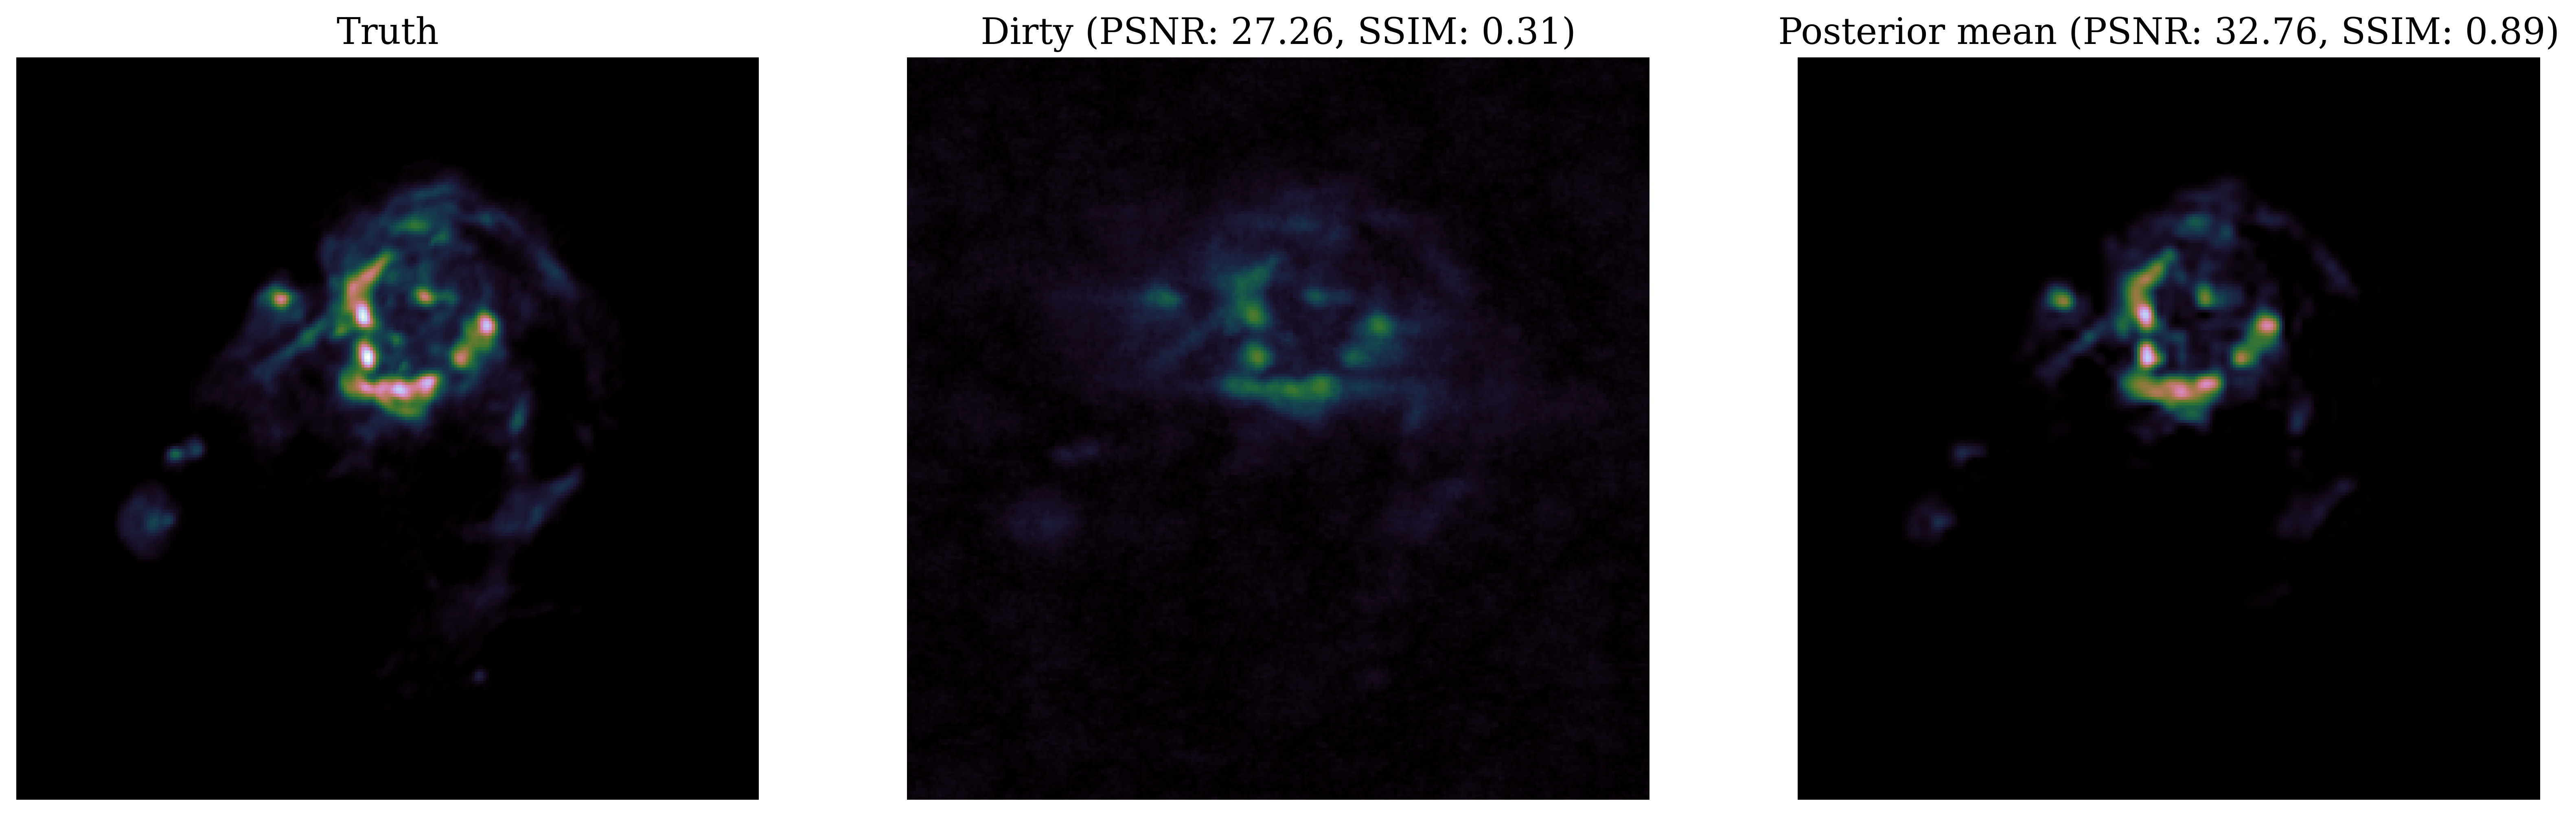

In [27]:
# WAV

images = [ground_truth, X0, NS_Trace_WAV['DiscardPostMean']]
labels = ["Truth", "Dirty", "Posterior mean"]

fig, axs = plt.subplots(1,3, figsize=(20,8), dpi=400)
for i in range(3):
    axs[i].imshow(images[i], cmap='cubehelix', vmax=np.nanmax(images), vmin=np.nanmin(images))
    if i > 0:   
        stats_str = ' (PSNR: {}, SSIM: {})'.format(
            round(psnr(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2),
            round(ssim(ground_truth, images[i], data_range=ground_truth.max()-ground_truth.min()), 2)
            )
        labels[i] += stats_str
    axs[i].set_title(labels[i], fontsize=16)
    axs[i].axis('off')


# plt.savefig('{:s}{:s}_reconstruction_plot.pdf'.format(save_fig_dir, save_prefix_WAV))
plt.show()
# plt.close()

dirty_WAV_SNR = psnr(ground_truth, X0, data_range=ground_truth.max()-ground_truth.min())
post_mean_WAV_SNR = psnr(ground_truth, NS_Trace_WAV['DiscardPostMean'], data_range=ground_truth.max()-ground_truth.min())



In [23]:

save_dict_WAV = {
    'ground_truth': ground_truth,
    'X0': X0,
    'dirty_SNR': dirty_WAV_SNR,
    'post_mean_SNR': post_mean_WAV_SNR,
    'NS_BayEvi': NS_BayEvi_WAV,
    'NS_Trace': NS_Trace_WAV,
    'options': options_WAV,
}

# try:
#     np.save('{:s}{:s}_saved_vars.pdf'.format(save_var_dir, save_prefix_WAV), save_dict_WAV, allow_pickle=True)
# except Exception as e:
#     print('cannot save variables')
#     print(e)



In [24]:


# old_stdout = sys.stdout
# log_file = open('{:s}{:s}_log.log'.format(save_var_dir, save_prefix_WAV), 'w')
# sys.stdout = log_file
print('Starting the log file.\n')


print('NS_BayEvi_DnCNN: ', NS_BayEvi_DnCNN)
print('NS_BayEvi_WAV: ', NS_BayEvi_WAV)

print('dirty_DnCNN_SNR: ', dirty_DnCNN_SNR)
print('post_mean_DnCNN_SNR: ', post_mean_DnCNN_SNR)

print('dirty_WAV_SNR: ', dirty_WAV_SNR)
print('post_mean_WAV_SNR: ', post_mean_WAV_SNR)


## Close log file
print('\n Good bye..')
# sys.stdout = old_stdout
# log_file.close()



Starting the log file.

NS_BayEvi_DnCNN:  [-3.76011298e+03  3.82686756e-01]
NS_BayEvi_WAV:  [-1.29117542e+04  4.41344217e-01]
dirty_DnCNN_SNR:  27.26390174674155
post_mean_DnCNN_SNR:  36.346426331124434
dirty_WAV_SNR:  27.26390174674155
post_mean_WAV_SNR:  32.76003680281225

 Good bye..


In [25]:
cmap = 'cubehelix'
save_dir = '/disk/xray0/tl3/repos/proxnest/debug/paper_plots/'
model_prefix = 'radio256'

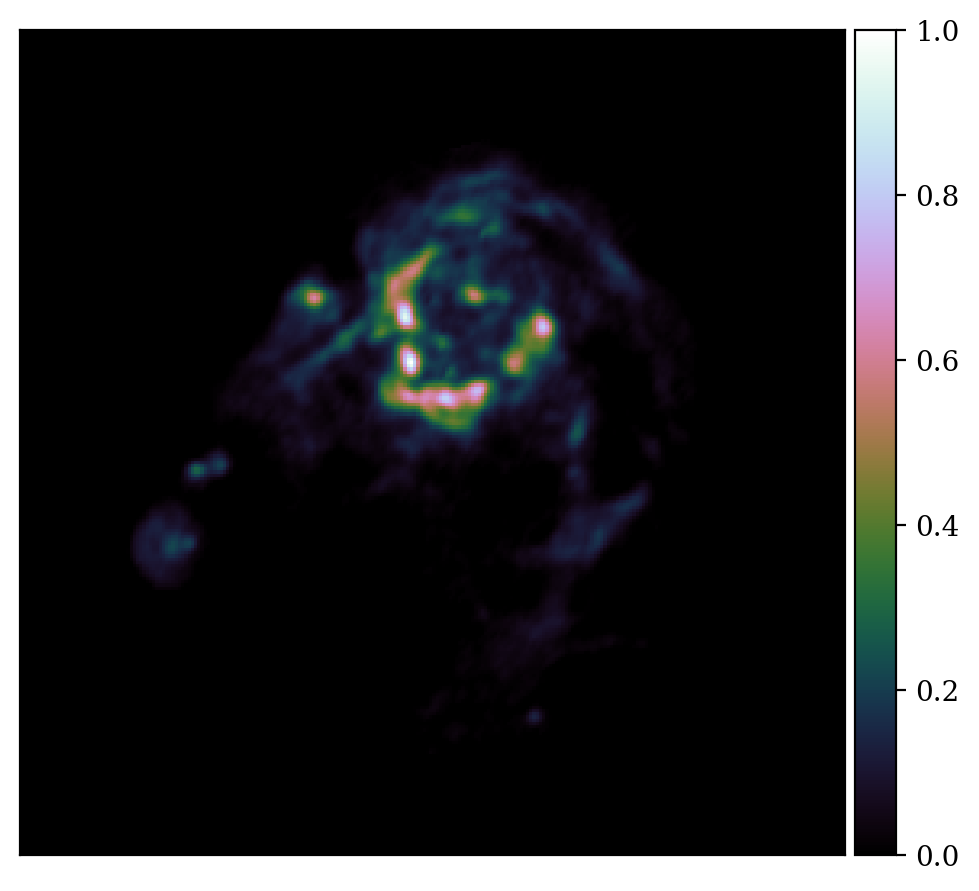

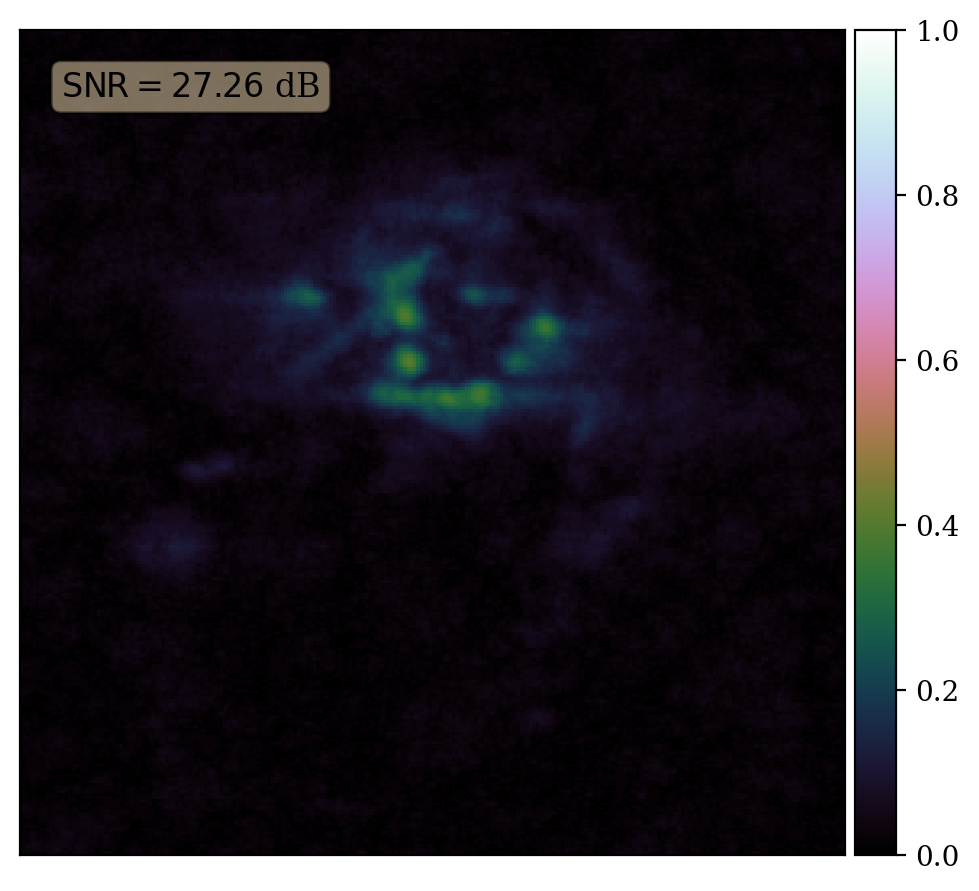

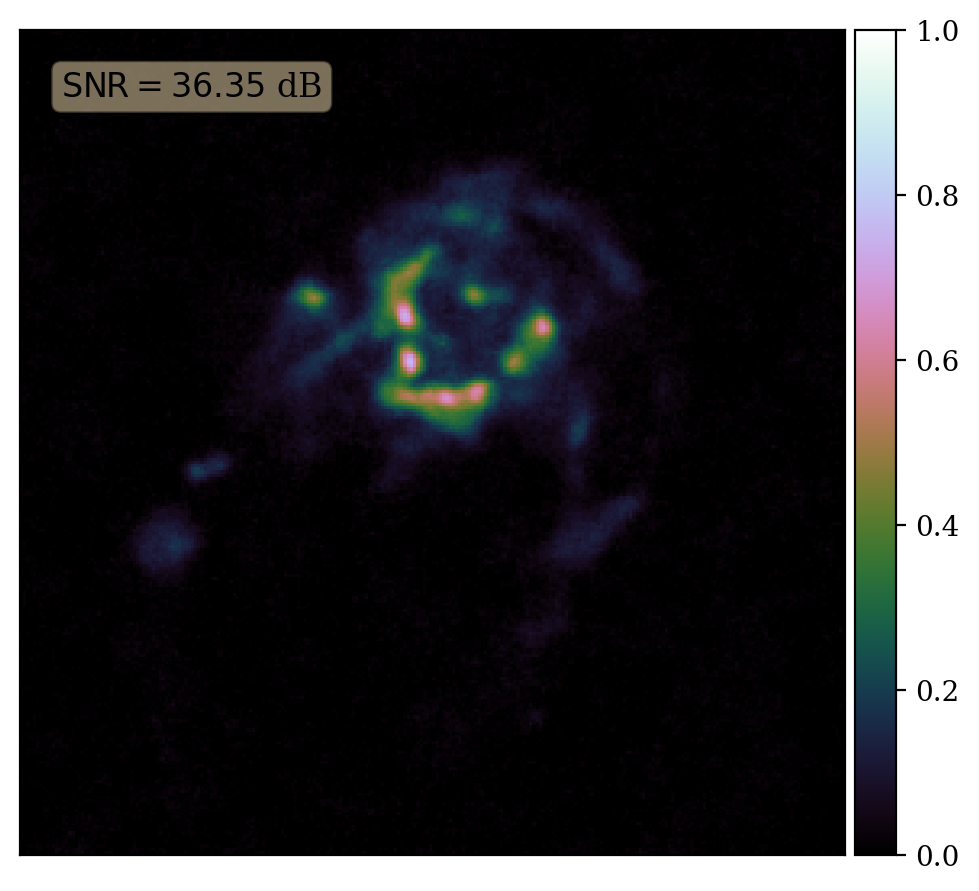

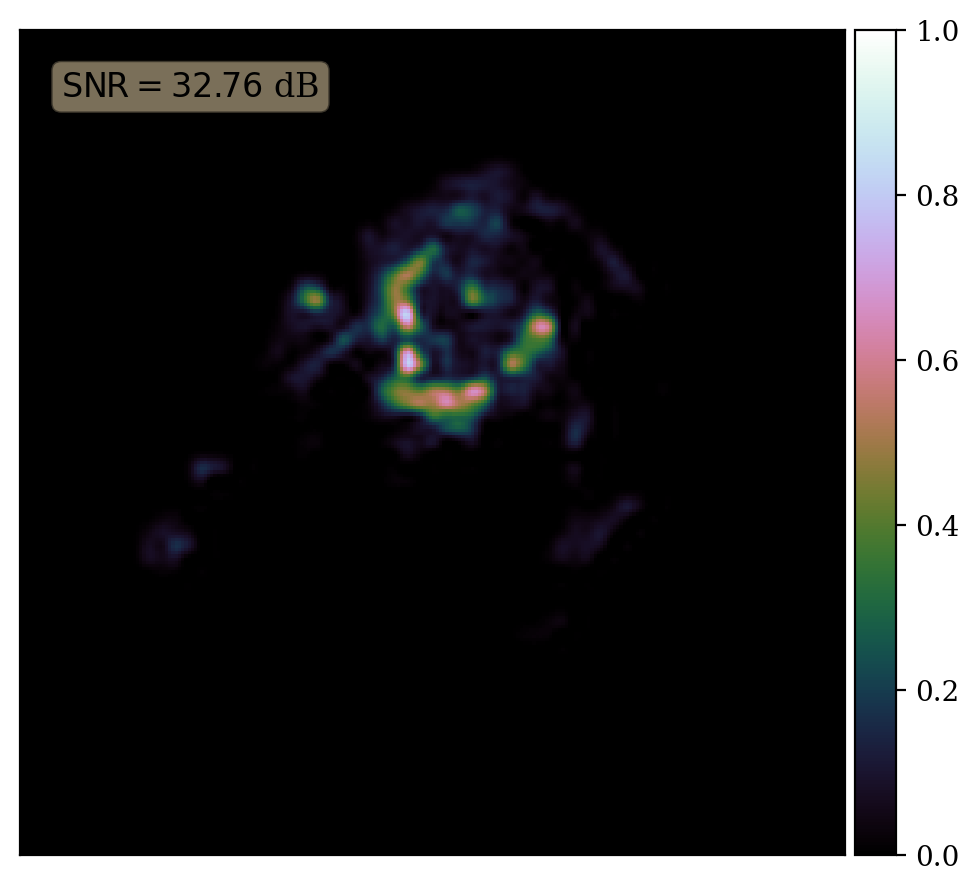

In [26]:
# Ground truth image
plot_img = ground_truth

fig = plt.figure(figsize=(5,5), dpi=200)
axs = plt.gca()
plt_im = axs.imshow(plot_img, cmap=cmap, vmin=0, vmax=1)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
axs.set_yticks([]);axs.set_xticks([])
plt.tight_layout()
plt.savefig(
    '{:s}{:s}{:s}'.format(save_dir, model_prefix, '-GroundTruth_image.pdf'),
    bbox_inches='tight',
    dpi=200
)
plt.show()


# Dirty image
plot_img = X0

# Compute SNR
map_snr = psnr(ground_truth, plot_img, data_range=ground_truth.max()-ground_truth.min())
# Plot MAP
fig = plt.figure(figsize=(5,5), dpi=200)
axs = plt.gca()
plt_im = axs.imshow(plot_img, cmap=cmap, vmin=0, vmax=1)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
axs.set_yticks([]);axs.set_xticks([])
textstr = r'$\mathrm{SNR}=%.2f$ dB'%(np.mean(map_snr))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs.text(
    0.05, 0.95, textstr, transform=axs.transAxes,
    fontsize=12, verticalalignment='top', bbox=props
)
plt.tight_layout()
plt.savefig(
    '{:s}{:s}{:s}'.format(save_dir, model_prefix, '-dirty_image.pdf'),
    bbox_inches='tight',
    dpi=200
)
plt.show()

## Posterior mean
plot_img = NS_Trace_DnCNN['DiscardPostMean']

# Compute SNR
map_snr = psnr(ground_truth, plot_img, data_range=ground_truth.max()-ground_truth.min())
# Plot MAP
fig = plt.figure(figsize=(5,5), dpi=200)
axs = plt.gca()
plt_im = axs.imshow(plot_img, cmap=cmap, vmin=0, vmax=1)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
axs.set_yticks([]);axs.set_xticks([])
textstr = r'$\mathrm{SNR}=%.2f$ dB'%(np.mean(map_snr))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs.text(
    0.05, 0.95, textstr, transform=axs.transAxes,
    fontsize=12, verticalalignment='top', bbox=props
)
plt.tight_layout()
plt.savefig(
    '{:s}{:s}{:s}'.format(save_dir, model_prefix, '-DnCNN-posterior_mean_image.pdf'),
    bbox_inches='tight',
    dpi=200
)
plt.show()


## Posterior mean
plot_img = NS_Trace_WAV['DiscardPostMean']

# Compute SNR
map_snr = psnr(ground_truth, plot_img, data_range=ground_truth.max()-ground_truth.min())
# Plot MAP
fig = plt.figure(figsize=(5,5), dpi=200)
axs = plt.gca()
plt_im = axs.imshow(plot_img, cmap=cmap, vmin=0, vmax=1)
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(plt_im, cax=cax)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.1f'))
axs.set_yticks([]);axs.set_xticks([])
textstr = r'$\mathrm{SNR}=%.2f$ dB'%(np.mean(map_snr))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
axs.text(
    0.05, 0.95, textstr, transform=axs.transAxes,
    fontsize=12, verticalalignment='top', bbox=props
)
plt.tight_layout()
plt.savefig(
    '{:s}{:s}{:s}'.format(save_dir, model_prefix, '-WAV-posterior_mean_image.pdf'),
    bbox_inches='tight',
    dpi=200
)
plt.show()

